In [1]:
import autograd.numpy as np
import numpy as pure_np
import autograd
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import pyamg

## Generate matrix with PyAMG and compute spectral radius with the default parameters

In [2]:
n = 63
num_levels = 5
grid_size = (n, n)

In [27]:
h = 1. / (n+1)
eps = 5e-4
A = pyamg.gallery.stencil_grid(np.array([[0, - eps - h, 0], 
                                         [-h - eps, 4. * eps + h * 2, - eps],
                                         [0, - eps, 0]]), 
                               grid_size, format="csr")

# A = pyamg.gallery.stencil_grid(np.array([-eps, 2*eps - h, -eps + h]), (n, ), format="csr") # Instable!
# A = pyamg.gallery.stencil_grid(np.array([-eps - h, 2*eps + h, -eps]), grid_size, format="csr")

In [28]:
print(A.min(), A.max())

-0.016125 0.03325


In [29]:
if len(grid_size) == 1:
    x_range = np.linspace(0, 1, num=n+2)
    x_range = x_range[1:-1]
    x_true = np.sin(np.pi * x_range)
    rhs = (eps * np.pi**2 * x_true + np.pi * np.cos(np.pi * x_range)) / (n+1)**2
    rhs = rhs.reshape(A.shape[0], 1)
elif len(grid_size) == 2:
    x0 = np.zeros((A.shape[0], 1))
    x_range = np.linspace(0, 1, num=n+2)
    x_range = x_range[1:-1]

    x_range, y_range = np.meshgrid(x_range, x_range)
    x_true = np.sin(np.pi * x_range) * np.sin(np.pi * y_range)
    rhs = (2 * np.pi**2 * x_true * eps + np.pi * np.sin(np.pi * (x_range + y_range))) / (n+1)**2
    rhs = rhs.reshape(A.shape[0], 1)
rhs.shape

(3969, 1)

In [30]:
ml = pyamg.ruge_stuben_solver(A, CF="RS", max_levels=num_levels, 
                             presmoother=('jacobi', {'omega': 2.0/3.0, 'iterations': 2, "withrho": False}),
                             postsmoother=('jacobi', {'omega': 2.0/3.0, 'iterations' : 2, "withrho": False})
                             )


print(ml)
num_levels = len(ml.levels)

multilevel_solver
Number of Levels:     5
Operator Complexity:  3.231
Grid Complexity:      2.140
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0         3969        19593 [30.95%]
    1         2196        14268 [22.54%]
    2         1254        11478 [18.13%]
    3          689        10015 [15.82%]
    4          384         7952 [12.56%]



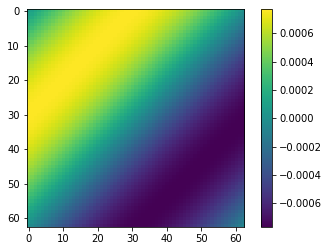

In [31]:
if len(grid_size) == 1:
    plt.plot(rhs.ravel())
elif len(grid_size) == 2:
    plt.imshow(rhs.reshape(n, n))
    plt.colorbar()

In [32]:
x = ml.solve(rhs, tol=1e-10)
x = x[:, np.newaxis]

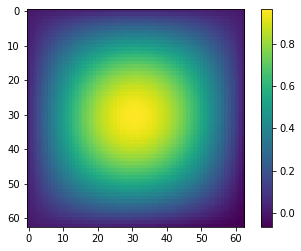

In [33]:
if len(grid_size) == 1:
    plt.plot(x)
elif len(grid_size) == 2:
    plt.imshow(x.reshape(n, n))
    plt.colorbar()

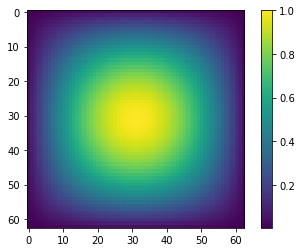

In [34]:
if len(grid_size) == 1:
    plt.plot(x_true)
elif len(grid_size) == 2:
    plt.imshow(x_true)
    plt.colorbar()

In [35]:
print("Residual norm = {}".format(np.linalg.norm(rhs-A.dot(x))))
if len(grid_size) == 2:
    print("Error = {}".format(np.linalg.norm(x_true - x.reshape(n, n))/np.linalg.norm(x_true.ravel())))
elif len(grid_size) == 1:
    print("Error = {}".format(np.linalg.norm(x_true - x.ravel()) / np.linalg.norm(x_true.ravel())))

Residual norm = 9.60498620058491e-13
Error = 0.0637997642595984


In [36]:
for l in ml.levels[:-1]:
    print(l.R.shape, l.A.shape, l.P.shape)
    print(l.A.min(), l.A.max())
print(ml.levels[-1].A.shape, ml.levels[-1].A.min(), ml.levels[-1].A.max())

(2196, 3969) (3969, 3969) (3969, 2196)
-0.016125 0.03325
(1254, 2196) (2196, 2196) (2196, 1254)
-0.016367481203007517 0.033507518796992486
(689, 1254) (1254, 1254) (1254, 689)
-0.016367481203007517 0.033801463862760346
(384, 689) (689, 689) (689, 384)
-0.01744639297484411 0.03742000974347902
(384, 384) -0.040833106530806976 0.13715625


In [37]:
def compute_spectral_radius_pyamg(pyamg_solver):
    n = pyamg_solver.levels[0].A.shape[0]
    M = spsplin.LinearOperator((n, n), 
                               matvec=lambda x: pyamg_solver.solve(np.zeros((n, 1)), x0=x, maxiter=1))
    rho = spsplin.eigs(M, k=1, return_eigenvectors=False, which="LM")[0]
    return abs(rho)

In [38]:
pyamg_rho = compute_spectral_radius_pyamg(ml)
print("Spectral radius for default parameters = {}".format(pyamg_rho))

Spectral radius for default parameters = 0.21215117418521826


## Custom implementation of V-cycle

In [39]:
import csr_compatible_primitives as csr_prim

In [40]:
def jacobi_smooth_sparse(A_values, A_indices, A_indptr, x0, b, w):
    x = x0
    n = x.shape[0]
    d = csr_prim.get_sparse_diag(A_values, A_indices, A_indptr, n)
    for i in range(2):
        Ax = csr_prim.csr_matvec(A_values, A_indptr, A_indices, x)
#         print(Ax.shape, b.shape, x.shape)
        x = x - w * (Ax - b) / d
    return x

In [41]:
def V_cycle(x0, b, A_values, A_indptr, A_indices, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   level=1, w=2.0/3.0):
    x = x0
    if level == 0:
        A_full = csr_prim.csr2dense(A_values[level], A_coarse_indices, A_coarse_indptr, A_coarse_indptr.shape[0] - 1)
        x = np.linalg.solve(A_full, b)
    else:
        x = jacobi_smooth_sparse(A_values[level], A_indices[level], A_indptr[level], x, b, w)
        Ax = csr_prim.csr_matvec(A_values[level], A_indptr[level], A_indices[level], x)
        res = b - Ax
        proj_res = csr_prim.csr_matvec(R_values[level], R_indptr[level], R_indices[level], res)
        e = np.zeros_like(proj_res)
        u = V_cycle(e, proj_res, A_values[:-1], A_indptr[:-1], A_indices[:-1],
                    P_values[:-1], P_indptr[:-1], P_indices[:-1], 
                    R_values[:-1], R_indptr[:-1], R_indices[:-1], 
                    level-1, w)
        Pu = csr_prim.csr_matvec(P_values[level], P_indptr[level], P_indices[level], u)
        x = x + Pu
        x = jacobi_smooth_sparse(A_values[level], A_indices[level], A_indptr[level], x, b, w)
    return x

In [42]:
A_list = [l.A.sorted_indices() for l in ml.levels]
# for A in A_list:
#     print(A.shape)

In [43]:
P_list = [l.P.sorted_indices() for l in ml.levels[:-1]]
# for P in P_list:
#     print(P.shape)

In [44]:
R_list = [l.R.sorted_indices() for l in ml.levels[:-1]]
# for R in R_list:
#     print(R.shape)

In [45]:
A_values = [A.data for A in A_list[::-1]]
A_indices = [A.indices for A in A_list[::-1]]
A_indptr = [A.indptr for A in A_list[::-1]]
A_coarse_indices = A_indices[0]
A_coarse_indptr = A_indptr[0]

In [46]:
P_values = [[]] + [P.data for P in P_list[::-1]]
P_indices = [[]] + [P.indices for P in P_list[::-1]]
P_indptr = [[]] + [P.indptr for P in P_list[::-1]]

In [47]:
R_values = [[]] + [R.data for R in R_list[::-1]]
R_indices = [[]] + [R.indices for R in R_list[::-1]]
R_indptr = [[]] + [R.indptr for R in R_list[::-1]]

In [48]:
x = np.zeros((A.shape[0], 1))
for i in range(10):
    x = V_cycle(x, rhs, A_values, A_indptr, A_indices, 
                       P_values, P_indptr, P_indices,
                       R_values, R_indptr, R_indices,
                       level=num_levels-1, w=2.0/3.0)
    print(np.linalg.norm(A.dot(x) - rhs))

0.01167528696470711
0.003638847770771595
0.0011147951015561596
0.0003191748289239086
8.696701525605225e-05
2.3280290852122406e-05
6.12275130694151e-06
1.5822037497236025e-06
4.0484004430891807e-07
1.0371690286224693e-07


### Compare spectral radius with PyAMG

In [49]:
def generate_all_A(A_csr_value, A_csr_indices, A_csr_indptr, 
                   P_values, P_indices, P_indptr, 
                   R_values, R_indices, R_indptr,
                   RAP_list_indices, RAP_list_indptr, level=1):
    
    A_values = [[] for i in range(level+1)]
    A_indices = RAP_list_indices + [A_csr_indices]
    A_indptr = RAP_list_indptr + [A_csr_indptr]
    A_values[level] = A_csr_value
#     A_indices[level] = A_csr_indices
#     A_indptr[level] = A_csr_indptr
    
    for l in range(level-1, -1, -1):
#         print("Level", l)
        n = A_indptr[l+1].shape[0] - 1
        n_coarse = R_indptr[l+1].shape[0] - 1
#         print("R info", R_values[l+1].shape)
#         print("A info", A_values[l+1].shape)
#         print("P info", P_values[l+1].shape)
        A_values[l], _, _ = csr_prim.csr_3mat(R_values[l+1], R_indptr[l+1], R_indices[l+1], 
                                     A_values[l+1], A_indptr[l+1], A_indices[l+1], 
                                     P_values[l+1], P_indptr[l+1], P_indices[l+1], 
                                     n_coarse, n, n, n_coarse)
#         print("Min A element in level {} = {}".format(l, np.min(abs(A_values[l]))))
#         print(A_values[l].shape, A_indices[l].shape)
    return A_values, A_indices, A_indptr

def multigrid_matvec(x, A_values, A_indptr, A_indices, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   level, w):
    
    rhs = np.zeros((A_indptr[-1].shape[0] - 1, 1))
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    y = V_cycle(x, rhs, A_values, A_indptr, A_indices, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   level, w)
    return y

def compute_spectral_radius_multigrid(A, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   level, w):
    A_values, A_indices_, A_indptr_ = generate_all_A(A.data, A.indices, A.indptr, P_values, P_indices, P_indptr, 
                   R_values, R_indices, R_indptr,
                   A_indices, A_indptr, level)
    M = spsplin.LinearOperator((A_indptr_[-1].shape[0] - 1, A_indptr_[-1].shape[0] - 1), 
                               matvec=lambda x: multigrid_matvec(x, A_values, A_indptr_, A_indices_, 
                                               P_values, P_indptr, P_indices,
                                               R_values, R_indptr, R_indices,
                                               level, w))
    rho = spsplin.eigs(M, k=1, return_eigenvectors=False, which="LM")[0]
    return abs(rho)

In [50]:
compute_spectral_radius_multigrid(A, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   level=num_levels-1, w=2./3)

0.21215117418516727

## Define all for optimization

In [51]:
def v_cycle_objective(R_values_active, P_values_active, w, x, num_levels):
    K = 10
    rhs = np.zeros((A.shape[0], num_trials))
    P_values = [[]] + P_values_active
    R_values = [[]] + R_values_active
    A_values, A_indices_, A_indptr_ = generate_all_A(A.data, A.indices, A.indptr, 
                                                   P_values, P_indices, P_indptr, 
                                                   R_values, R_indices, R_indptr,
                                                   A_indices, A_indptr, 
                                                   num_levels)
    for i in range(K):
        x = V_cycle(x, rhs, A_values, A_indptr_, A_indices_, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   num_levels, w)
    loss = np.linalg.norm(x, "fro")**2
    return np.log(loss)

In [52]:
R_values_active = [R.data for R in R_list[::-1]]
P_values_active = [P.data for P in P_list[::-1]]
w = 2./3
num_trials = 5
x_batch = 2 * np.random.randint(0, 2, (A.shape[0], num_trials)) - 1
v_cycle_objective(R_values_active, P_values_active, w, x_batch, num_levels=num_levels-1)

-18.70697160835925

In [53]:
grad = autograd.grad(v_cycle_objective, 0)

In [54]:
grad(R_values_active, P_values_active, w, x_batch, num_levels=num_levels-1)

[array([-1.32783716e-04, -5.17285789e-04, -7.20307538e-04, ...,
        -1.00946153e-04,  5.68282194e-05,  2.86408319e-05]),
 array([-9.40973419e-04, -3.00307899e-04, -1.58344347e-03, ...,
         6.32594673e-04,  5.93579059e-04,  1.92569582e-05]),
 array([ 1.10625133e-03, -6.88392442e-04, -2.27506075e-03, ...,
         3.26172533e-04,  1.14327822e-05, -6.68203640e-05]),
 array([-6.99127725e-03, -1.56869769e-02, -1.40926300e-02, ...,
         5.06591842e-05,  6.08032837e-06, -2.01960337e-04])]

In [55]:
# %timeit grad(R_values_active, P_values_active, w, x_batch, num_levels=num_levels-1)

### Optimization utilities

In [56]:
from autograd.misc import flatten
from autograd.wrap_util import wraps

def unflatten_optimizer(optimize):
    """Takes an optimizer that operates on flat 1D numpy arrays and returns a
    wrapped version that handles trees of nested containers (lists/tuples/dicts)
    with arrays/scalars at the leaves."""
    @wraps(optimize)
    def _optimize(grad, x0, callback=None, *args, **kwargs):
        _x0, unflatten = flatten(x0)
        _grad = lambda x, i: flatten(grad(unflatten(x), i))[0]
        if callback:
            _callback = lambda x, i, g, num_iter, *args, **kwargs: callback(unflatten(x), i, unflatten(g), num_iter, *args, **kwargs)
        else:
            _callback = None
        return unflatten(optimize(_grad, _x0, _callback, *args, **kwargs))

    return _optimize

In [57]:
@unflatten_optimizer
def adam(grad, x, callback=None, num_iters=100,
         step_size=0.001, b1=0.9, b2=0.999, eps=10**-8, *args, **kwargs):
    """Adam as described in http://arxiv.org/pdf/1412.6980.pdf.
    It's basically RMSprop with momentum and some correction terms."""
    m = np.zeros(len(x))
    v = np.zeros(len(x))
    for i in range(num_iters):
#         print(i)
#         print(x.shape)
        g = grad(x, i)
        if callback: callback(x, i, g, num_iters, *args, **kwargs)
        m = (1 - b1) * g      + b1 * m  # First  moment estimate.
        v = (1 - b2) * (g**2) + b2 * v  # Second moment estimate.
        mhat = m / (1 - b1**(i + 1))    # Bias correction.
        vhat = v / (1 - b2**(i + 1))
        x = x - step_size*mhat/(np.sqrt(vhat) + eps)
    return x

In [58]:
def my_test_callback(params, current_iter, gradient, num_iters):
    if current_iter == 0 or (current_iter + 1) % 100 == 0:
        print("Iteration {}".format(current_iter + 1))
#         print("Spectral radius = {}".format(compute_spectral_radius_multigrid(A, 
#                    [[]] + params[1], P_indptr, P_indices,
#                    [[]] + params[0], R_indptr, R_indices,
#                    num_levels-1, params[2])))
        u = np.random.randint(0, 2, size=(A.shape[0], num_trials))
        u = 2 * u - 1
        print("Current objective value = {}".format(v_cycle_objective(params[0], params[1], params[2], 
                                                                      u, num_levels=num_levels-1)))

In [59]:
def obj(param, n_iter):
    x = 2 * np.random.randint(0, 2, (A.shape[0], num_trials)) - 1
    return objective(param[0], param[1], param[2], x)

def v_cycle_obj(param, n_iter):
    x = 2 * np.random.randint(0, 2, (A.shape[0], num_trials)) - 1
    return v_cycle_objective(param[0], param[1], param[2], x, num_levels=num_levels-1)

grad_v_cycle_obj = autograd.grad(v_cycle_obj)
num_iters = 1000
step_size = 1e-4

In [60]:
# grad_v_cycle_obj((R_values_active, P_values_active, w), 0)

In [61]:
PRd_opt = adam(grad_v_cycle_obj, (R_values_active, P_values_active, w), my_test_callback, num_iters, step_size, 0.9, 0.999, 10**-8)

Iteration 1
Current objective value = -18.018330694038866


ValueError: indices and data should have the same size

In [196]:
print("Spectral radius = {}".format(compute_spectral_radius_multigrid(A, 
                   [[]] + PRd_opt[1], P_indptr, P_indices,
                   [[]] + PRd_opt[0], R_indptr, R_indices,
                   num_levels-1, PRd_opt[2])))

Spectral radius = 0.06700278973550922
